In [30]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

import keras


from keras.preprocessing.image import ImageDataGenerator


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report


In [31]:
image_size = 200
labels = ['PNEUMONIA', 'NORMAL']
scale = 0.1
epochs=10

### Récupération des datasets en échelle de gris

In [32]:
def get_training_data(data_dir):
    data = list()
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for image in os.listdir(path):
            if(image!=".DS_Store"):
                try:
                    image_arr = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(image_arr, (image_size, image_size)) 
                    data.append([resized_arr, class_num])
                except Exception as e:
                    print(e)
    # return np.array(data, dtype="object")
    dataset= np.array(data, dtype="object")
    return dataset[np.random.randint(dataset.shape[0], size=int(len(dataset)*scale)), :]

In [33]:
trainData = get_training_data('chest_xray/train')
testData = get_training_data('chest_xray/test')
valData = get_training_data('chest_xray/val')
print(f"Train: {len(trainData)}, Test: {len(testData)}, Val: {len(valData)}")

Train: 521, Test: 62, Val: 1


### Affichage d'une image du dataset de data  
/!\ passer paramètre plt.cm.gray à imshow sinon plt transforme le vecteur gris de cv2 en vert

Text(0.5, 1.0, 'PNEUMONIA')

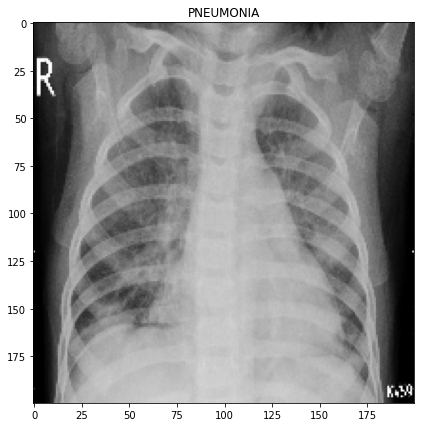

In [34]:
plt.figure(figsize = (7, 7))
plt.imshow(trainData[2][0], cmap = plt.cm.gray)
plt.title(labels[trainData[2][1]])

#### Tresholding : technique de segmentation pour séparer le premier plan du background


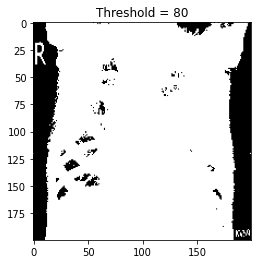

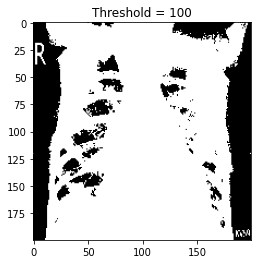

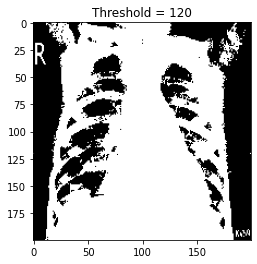

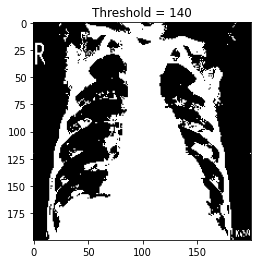

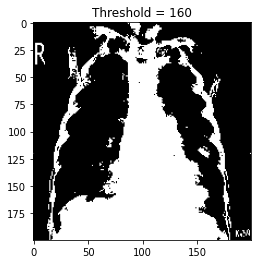

In [35]:
sample = trainData[2][0]

rgb = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

thresholds = [80, 100, 120, 140, 160]
for threshold in thresholds:
    val, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh, cmap='gray')
    plt.title(f"Threshold = {threshold}")
    plt.show()

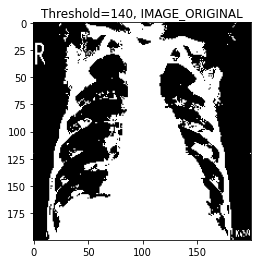

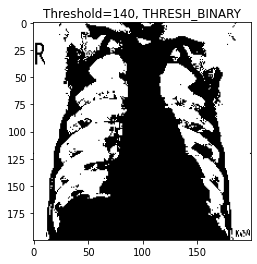

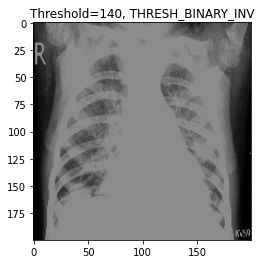

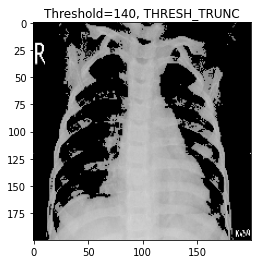

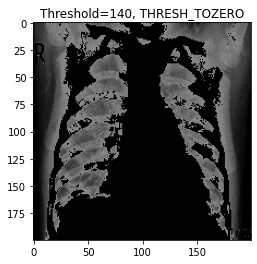

In [36]:
def show_threshold(image, threshold):
    cv2_threshs = [cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC,
                  cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV]
    
    names = ['IMAGE_ORIGINAL', 'THRESH_BINARY', 'THRESH_BINARY_INV', 'THRESH_TRUNC',
                'THRESH_TOZERO', 'THRESH_TOZERO_INV']
    
    
    for name, cv2_thresh in zip(names, cv2_threshs):
        val, image_new = cv2.threshold(image, threshold, 255, cv2_thresh)
        plt.imshow(cv2.cvtColor(image_new, cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title(f"Threshold={threshold}, {name}")
        plt.show()
show_threshold(gray, 140)

In [37]:

def prepare_dataset(dataset):
    X_ = list()
    y_ = list()
    for features, label in dataset:
        X_.append(features)
        y_.append(label)
    X_ = np.array(X_)/255
    X_ = X_.reshape(-1, image_size, image_size, 1)
    y_ = np.array(y_)
    return X_, y_


In [38]:
X_train, y_train = prepare_dataset(trainData)
X_test, y_test = prepare_dataset(testData)

#### ImageDataGenerator :  
 applique à un batch d’images, des transformations choisies de façon aléatoire et remplace le batch d’origine par ces nouvelles donnée

In [39]:
def data_argumentation(datagen=None):
    if datagen is None:
        return ImageDataGenerator(
                    featurewise_center=False, 
                    samplewise_center=False, 
                    featurewise_std_normalization=False,  
                    samplewise_std_normalization=False, 
                    zca_whitening=False,  
                    rotation_range = 30) 
    return datagen
                

In [40]:
datagenerator = data_argumentation()

In [41]:
datagenerator.fit(X_train)

In [42]:
def model_v1(img_size):
    model_v1 = Sequential()
    
    model_v1.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=img_size))
    model_v1.add(BatchNormalization())
    model_v1.add(MaxPool2D((2,2), strides=2, padding='same'))

    model_v1.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model_v1.add(Dropout(0.2))

    model_v1.add(BatchNormalization())
    model_v1.add(MaxPool2D((2,2), strides=2, padding='same'))
    model_v1.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))

    model_v1.add(BatchNormalization())
    model_v1.add(MaxPool2D((2,2), strides=2, padding='same'))
    model_v1.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    model_v1.add(Dropout(0.2))

    model_v1.add(BatchNormalization())
    model_v1.add(MaxPool2D((2,2), strides = 2, padding='same'))

    model_v1.add(Flatten())
    model_v1.add(Dense(units=128, activation='relu'))
    model_v1.add(Dropout(0.2))
    model_v1.add(Dense(2, activation='softmax'))
    
    return model_v1

In [43]:
def model_v2(img_size):
    model_v2 = Sequential()
    model_v2.add(Conv2D(32, (3, 3), activation='relu', input_shape=img_size))
    model_v2.add(MaxPool2D((2, 2)))
    model_v2.add(Dropout(0.2))

    model_v2.add(Conv2D(64, (3, 3), activation='relu'))
    model_v2.add(MaxPool2D((2, 2)))
    model_v2.add(Dropout(0.2))

    model_v2.add(Conv2D(64, (3, 3), activation='relu'))
    model_v2.add(MaxPool2D((2, 2)))
    model_v2.add(Dropout(0.2))

    model_v2.add(Conv2D(128, (3, 3), activation='relu'))
    model_v2.add(MaxPool2D((2, 2)))

    model_v2.add(Flatten())
    model_v2.add(Dense(120))
    model_v2.add(Dropout(0.4))
    model_v2.add(Dense(2, activation='softmax'))

    return model_v2

In [44]:
model_v1 = model_v1((image_size, image_size, 1))
model_v2 = model_v2((image_size, image_size, 1))

In [45]:
model_v1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_v1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_8 (Batc  (None, 200, 200, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 100, 100, 64)      18496     
                                                                 
 dropout_10 (Dropout)        (None, 100, 100, 64)      0         
                                                                 
 batch_normalization_9 (Batc  (None, 100, 100, 64)    

In [46]:
model_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_v2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 99, 99, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 48, 48, 64)       

#### ModelCheckpoint :  
Sauvegarde du meilleur model (parametre save_best_only)

#### EarlyStopping :  
Quand plus d'évolution, stop du model


In [47]:
def callbacks():
    callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath='lstmchar256256128test.h5',
                monitor='loss',
                save_best_only=True
            ),
            keras.callbacks.EarlyStopping(
                monitor='loss',
                min_delta=0,
                patience=8,
                mode='auto',
                baseline=None,
            )
        ]
    return callbacks

### Fit :  
Entrainement avec les valeurs de train, ajustement des neurones

In [48]:
history_v1 = model_v1.fit(datagenerator.flow(X_train, y_train, batch_size=32),
                    epochs=epochs, callbacks=callbacks())

Epoch 1/10
17/17 [==============================] - 21s 1s/step - loss: 3.8136 - accuracy: 0.7524
Epoch 2/10
17/17 [==============================] - 19s 1s/step - loss: 0.3178 - accuracy: 0.9155
Epoch 3/10
17/17 [==============================] - 19s 1s/step - loss: 0.1600 - accuracy: 0.9501
Epoch 4/10
17/17 [==============================] - 19s 1s/step - loss: 0.2418 - accuracy: 0.9098
Epoch 5/10
17/17 [==============================] - 19s 1s/step - loss: 0.1663 - accuracy: 0.9405
Epoch 6/10
17/17 [==============================] - 19s 1s/step - loss: 0.1641 - accuracy: 0.9443
Epoch 7/10
17/17 [==============================] - 19s 1s/step - loss: 0.1265 - accuracy: 0.9501
Epoch 8/10
17/17 [==============================] - 19s 1s/step - loss: 0.1140 - accuracy: 0.9520
Epoch 9/10
17/17 [==============================] - 19s 1s/step - loss: 0.0725 - accuracy: 0.9750
Epoch 10/10
17/17 [==============================] - 19s 1s/step - loss: 0.1096 - accuracy: 0.9578


In [49]:
history_v2 = model_v2.fit(datagenerator.flow(X_train, y_train, batch_size=32),
                    epochs=epochs, callbacks=callbacks())

Epoch 1/10
17/17 [==============================] - 12s 664ms/step - loss: 0.7504 - accuracy: 0.7313
Epoch 2/10
17/17 [==============================] - 11s 644ms/step - loss: 0.5507 - accuracy: 0.7601
Epoch 3/10
17/17 [==============================] - 11s 644ms/step - loss: 0.5455 - accuracy: 0.7678
Epoch 4/10
17/17 [==============================] - 11s 644ms/step - loss: 0.5220 - accuracy: 0.7620
Epoch 5/10
17/17 [==============================] - 11s 649ms/step - loss: 0.3586 - accuracy: 0.8119
Epoch 6/10
17/17 [==============================] - 11s 644ms/step - loss: 0.3274 - accuracy: 0.8503
Epoch 7/10
17/17 [==============================] - 11s 681ms/step - loss: 0.2578 - accuracy: 0.8868
Epoch 8/10
17/17 [==============================] - 11s 674ms/step - loss: 0.2626 - accuracy: 0.8983
Epoch 9/10
17/17 [==============================] - 11s 651ms/step - loss: 0.2357 - accuracy: 0.9060
Epoch 10/10
17/17 [==============================] - 11s 648ms/step - loss: 0.2145 - accura

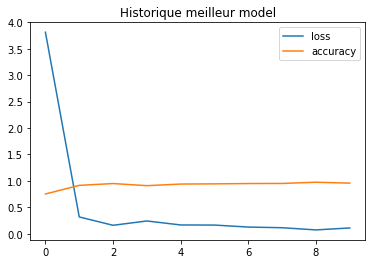

In [50]:
history_loss = history_v1.history["loss"]
history_acc = history_v1.history["accuracy"]

plt.plot(history_loss, label="loss")
plt.plot(history_acc, label="accuracy")
plt.title("Historique meilleur model")
plt.legend()

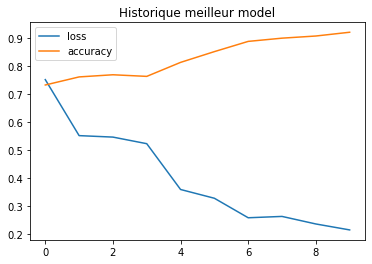

In [51]:
history_loss = history_v2.history["loss"]
history_acc = history_v2.history["accuracy"]

plt.plot(history_loss, label="loss")
plt.plot(history_acc, label="accuracy")
plt.title("Historique meilleur model")
plt.legend()

#### predict :
Utilisation du model pour la détermination de la pneumonie.
On ajuste plus, on test notre model avec notre dataset de test.

In [52]:
predict_x=model_v1.predict(X_test) 
classes_x=np.argmax(predict_x, axis=1)
len(classes_x), len(X_test)

(62, 62)

In [53]:
print(classification_report(y_test, classes_x, target_names=labels))

              precision    recall  f1-score   support

   PNEUMONIA       0.65      1.00      0.78        40
      NORMAL       0.00      0.00      0.00        22

    accuracy                           0.65        62
   macro avg       0.32      0.50      0.39        62
weighted avg       0.42      0.65      0.51        62



/Users/killian/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/killian/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/killian/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
predict_x=model_v2.predict(X_test) 
classes_x=np.argmax(predict_x, axis=1)
len(classes_x), len(X_test)

(62, 62)

In [55]:
print(classification_report(y_test, classes_x, target_names=labels))

              precision    recall  f1-score   support

   PNEUMONIA       0.77      0.93      0.84        40
      NORMAL       0.79      0.50      0.61        22

    accuracy                           0.77        62
   macro avg       0.78      0.71      0.73        62
weighted avg       0.78      0.77      0.76        62

